<a href="https://colab.research.google.com/github/ritzx21/Credit-Card-Fraud-Detection-DS-PBL/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings


warnings.filterwarnings("ignore")

In [13]:
data = pd.read_csv('/content/creditcard.csv')

In [14]:
# Data preprocessing
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

# Splitting into features and target
X = data.drop('Class', axis=1)
y = data['Class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [19]:
# Impute or remove NaN values in y_train
y_train_imputed = y_train.fillna(y_train.mean())


In [20]:
print("Number of NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Number of NaN values in X_test_scaled:", np.isnan(X_test_scaled).sum())

Number of NaN values in X_train_scaled: 0
Number of NaN values in X_test_scaled: 0


In [21]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Neural Network': MLPClassifier()
}

In [22]:
threshold = 0.5  # Set a threshold to determine fraud (1) and non-fraud (0)
y_train_binary = (y_train_imputed > threshold).astype(int)

# Model training and evaluation
results = {}
for name, model in models.items():
    # Fit the model to the training data with binary labels
    model.fit(X_train_scaled, y_train_binary)

    if isinstance(model, SVC) and not model.probability:
        # Use decision_function instead
        y_pred_scores = model.decision_function(X_test_scaled)
        y_pred_proba = (y_pred_scores - y_pred_scores.min()) / (y_pred_scores.max() - y_pred_scores.min())  # Normalize scores
    else:
        # Use predict_proba for other models
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    results[name] = {'confusion_matrix': cm, 'precision_recall_auc': pr_auc}

In [23]:
for name, result in results.items():
    print(name)
    print("AUPRC:", result['precision_recall_auc'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print()

Logistic Regression
AUPRC: 0.8360312640272409
Confusion Matrix:
[[3964    2]
 [   2   12]]

Random Forest
AUPRC: 0.9252972226186511
Confusion Matrix:
[[3965    1]
 [   2   12]]

Gradient Boosting
AUPRC: 0.8142100459064744
Confusion Matrix:
[[3963    3]
 [   1   13]]

Support Vector Machine
AUPRC: 0.9213169766741196
Confusion Matrix:
[[3965    1]
 [   3   11]]

Neural Network
AUPRC: 0.888185039688799
Confusion Matrix:
[[3965    1]
 [   2   12]]



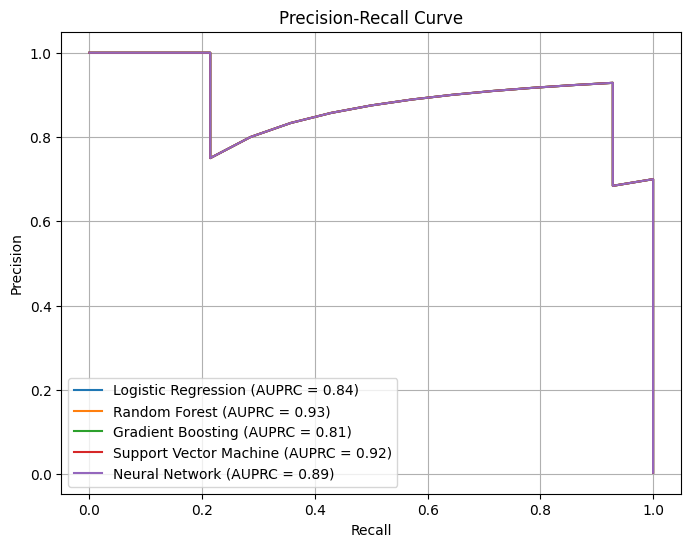

In [24]:
plt.figure(figsize=(8, 6))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{name} (AUPRC = {result['precision_recall_auc']:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [25]:

from sklearn.metrics import accuracy_score

accuracies = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

print("Model Accuracies:")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy:.4f}")

Model Accuracies:
Logistic Regression: 0.9990
Random Forest: 0.9992
Gradient Boosting: 0.9990
Support Vector Machine: 0.9990
Neural Network: 0.9992


Accuracy high because fraudulent cases rare in dataset

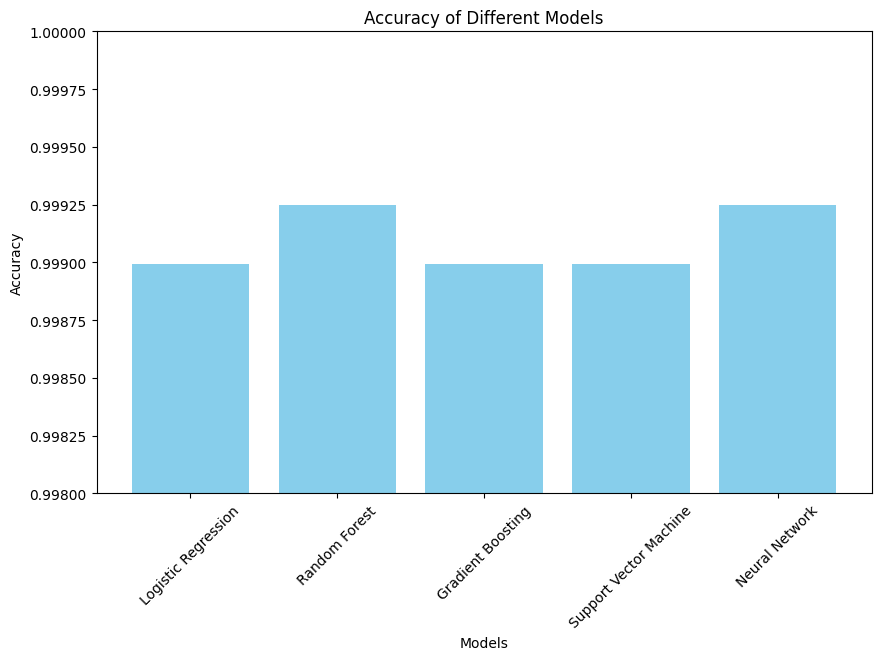

In [26]:
import matplotlib.pyplot as plt

# Extract model names and accuracy scores
model_names = list(accuracies.keys())
accuracy_scores = list(accuracies.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.998, 1)  # Set y-axis limits to better visualize differences
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()